# ID5059 Group Project
## Weather Prediction

### 1. Data Preprocessing

In [4]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as PathEffects


import numpy as np
import seaborn as sns

from scipy.interpolate import griddata

In [5]:
randomSeed = 1

#### 1.1 Load the data

In [6]:
# function reads in data from file
def loadData(fileName, filePath = "./", deliniator = ","):
    path = Path() / filePath / fileName; print(path)
    if not path.is_file():
        raise Exception("File not found")
    
    return pd.read_csv(path, sep = deliniator)

In [7]:
# read in training data
# no need to load in test data until it needs to be used
# takes ~20s to run
filePath = "./"

dataTrain = loadData("train.csv", filePath)

train.csv


In [9]:
dataTrain.shape

(13288920, 13)

In [10]:
dataTrain.head(2)

id           valid_time  latitude  longitude        tp       u10       v10  \
0   1  2018-01-01 00:00:00      59.0      -8.00  0.000004  1.405868 -1.367767   
1   2  2018-01-01 00:00:00      59.0      -7.75  0.000017  2.151962 -1.555267   

         sp      u100      v100       tcc  ptype        t2m  
0  98134.81  1.516388 -1.468002  0.968842    1.0  279.75903  
1  98086.81  2.239044 -1.634994  0.978790    1.0  279.61255

#### 1.2 Drop Unique Identifier
We see that the data has a unique identifier, "id". This interferes with the model making predictions, and is, therefore, dropped.

In [11]:
dataTrain.drop(["id"], axis = 1, inplace = True)
print(dataTrain.shape)
dataTrain.head(2)

(13288920, 12)


valid_time  latitude  longitude        tp       u10       v10  \
0  2018-01-01 00:00:00      59.0      -8.00  0.000004  1.405868 -1.367767   
1  2018-01-01 00:00:00      59.0      -7.75  0.000017  2.151962 -1.555267   

         sp      u100      v100       tcc  ptype        t2m  
0  98134.81  1.516388 -1.468002  0.968842    1.0  279.75903  
1  98086.81  2.239044 -1.634994  0.978790    1.0  279.61255

#### 1.3 Check for Null/Empty Values

In [12]:
# Check data types
print("Training data types:")
dataTrain.dtypes

# Summary statistics
print("\nSummary statistics for numerical columns:")
dataTrain.describe()

# Check for missing values
print("\nMissing values in training data:")
print(dataTrain.isnull().sum())

Training data types:

Summary statistics for numerical columns:

Missing values in training data:
valid_time    0
latitude      0
longitude     0
tp            0
u10           0
v10           0
sp            0
u100          0
v100          0
tcc           0
ptype         0
t2m           0
dtype: int64


#### 1.4 Convert valid_time into More Usable Columns | Implementing Seasons
The valid_time column is not currently in a format that is particularly helpful. Want to split into year, month, day, hour, and season categories -- these categories are unorded, and should later be one hot encoded.

In [13]:
def convertDateTimeToComponents(data, column):
    data["year"] = data[column].dt.year
    data["month"] = data[column].dt.month
    data["day"] = data[column].dt.day
    data["hour"] = data[column].dt.hour
    data["season"] = (data["month"] & 12 + 3) // 3
    
    return data

In [14]:
# Convert 'valid_time' to datetime
# takes ~6s to run
dataTrain['valid_time'] = pd.to_datetime(dataTrain['valid_time'])
dataTrain = convertDateTimeToComponents(dataTrain, "valid_time")

dataTrain[['valid_time', 'year', 'month', 'day', 'hour', 'season']].head()

valid_time  year  month  day  hour  season
0 2018-01-01  2018      1    1     0       0
1 2018-01-01  2018      1    1     0       0
2 2018-01-01  2018      1    1     0       0
3 2018-01-01  2018      1    1     0       0
4 2018-01-01  2018      1    1     0       0

In [15]:
dataTrain.shape

(13288920, 17)

Now we want to drop valid_time, as it represents the same thing as our separated chronological data, but isn't in a useful format.

In [16]:
dataTrain.drop(["valid_time"], axis = 1, inplace = True)
print(dataTrain.shape)
dataTrain.head(2)

(13288920, 16)


latitude  longitude        tp       u10       v10        sp      u100  \
0      59.0      -8.00  0.000004  1.405868 -1.367767  98134.81  1.516388   
1      59.0      -7.75  0.000017  2.151962 -1.555267  98086.81  2.239044   

       v100       tcc  ptype        t2m  year  month  day  hour  season  
0 -1.468002  0.968842    1.0  279.75903  2018      1    1     0       0  
1 -1.634994  0.978790    1.0  279.61255  2018      1    1     0       0

#### 1.5 Plot Distributions of Variables

In [25]:
# sample 0.1% of dataset
N = int( 0.001 * dataTrain.shape[0] )

In [17]:
# Create a function to plot histograms for all numerical features
def plot_feature_distributions(df, columns=None, bins=30, figsize=(16, 12)):
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        
    n_cols = 3
    n_rows = (len(columns) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.histplot(df[col], kde=True, bins=bins, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    plt.tight_layout()
    plt.show()

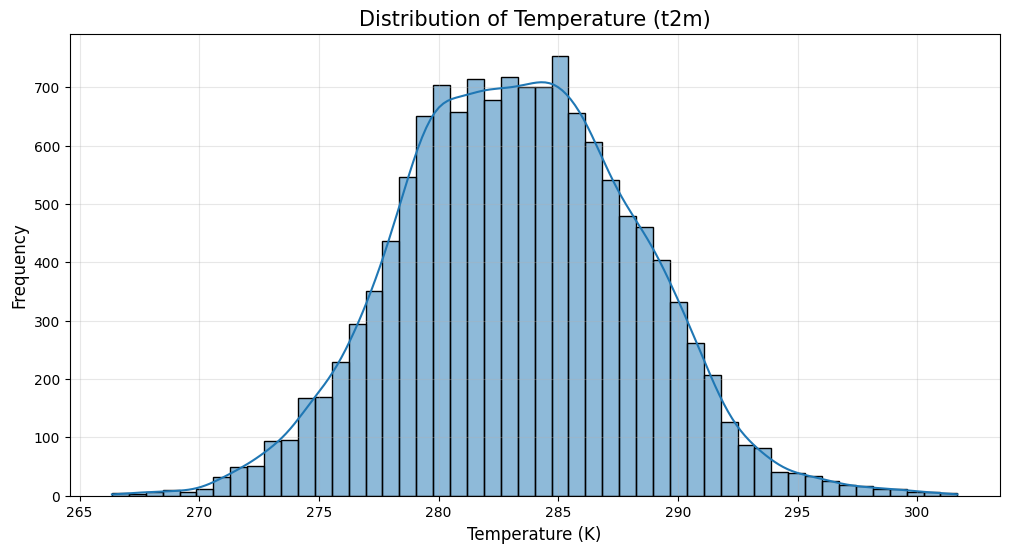

In [18]:
# Distribution of target variable
plt.figure(figsize=(12, 6))
sns.histplot(dataTrain['t2m'].sample(N, random_state = randomSeed), kde=True, bins=50)
plt.title('Distribution of Temperature (t2m)', fontsize=15)
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

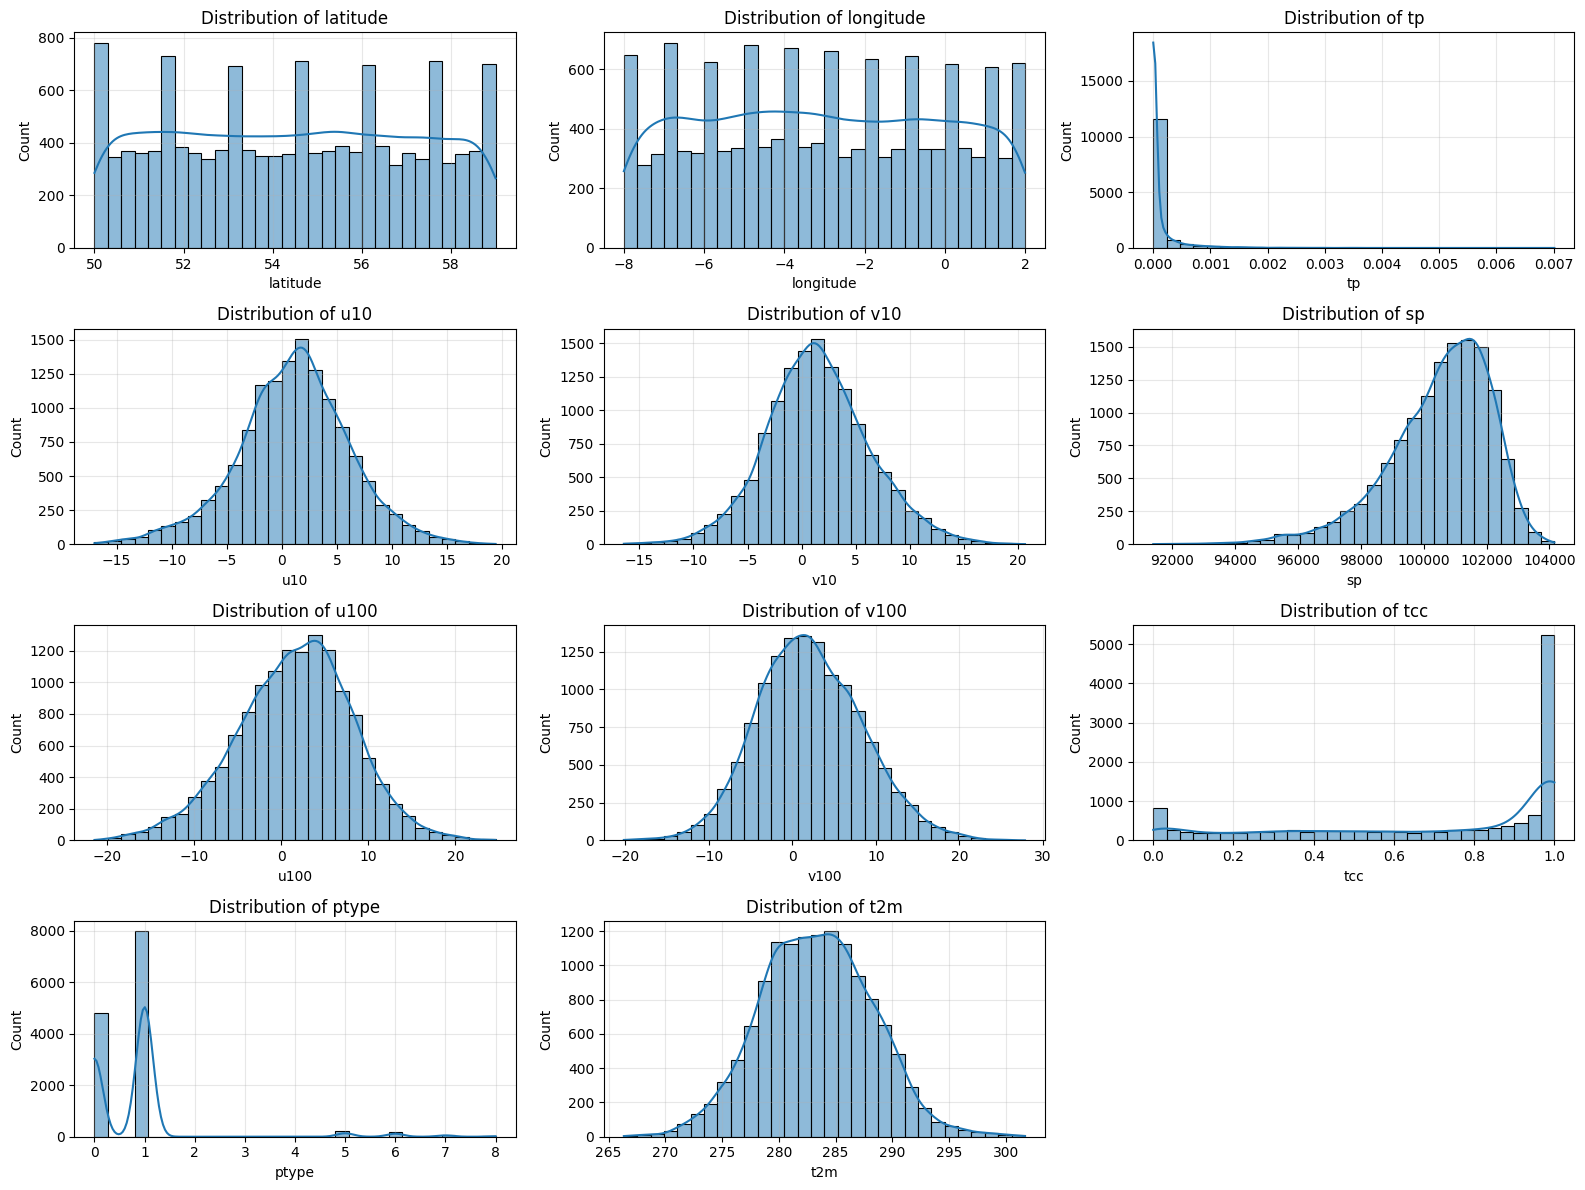

In [19]:
# Plot distributions of all continuous features (excluding datetime and ID)
numeric_cols = dataTrain.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['id', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear']]
plot_feature_distributions(dataTrain.sample(N, random_state = randomSeed), columns=numeric_cols)

#### 1.6 Plot Distributions of Variables With Respect to Response

In [20]:
# plotting distributions for each variable
# running with all entries in dataset takes ~10mins
# therefore run with random sample n from dataset
def plotResponseDistributions(data, x, y):
    plot = sns.PairGrid(data, x_vars = x, y_vars = y, height = 5, aspect = 1.5)
    plot.map(sns.scatterplot)

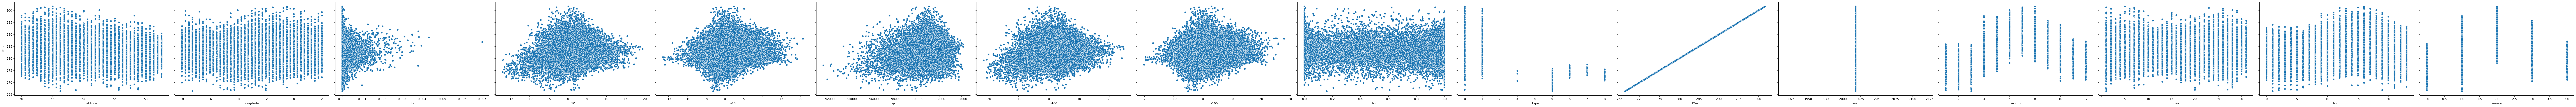

In [21]:
plotResponseDistributions(dataTrain.sample(N, random_state = randomSeed), dataTrain.columns.tolist(), ["t2m"])

Below plots show temperature along the x-axis, and the variables along the y-axis. Initially wanted this the opposite way, but they displayed inline and too small to be properly legisble.

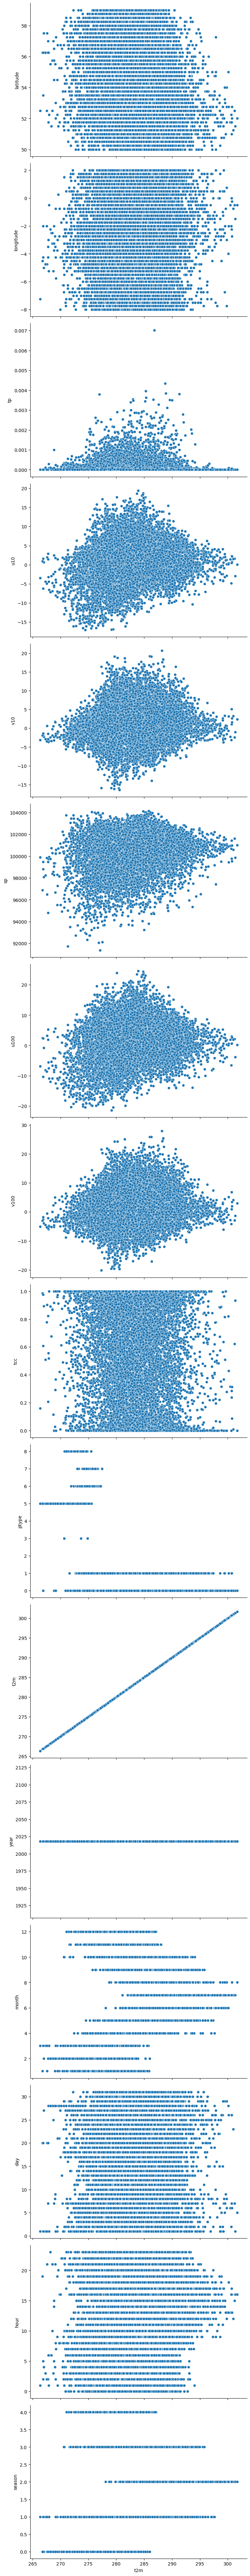

In [22]:
plotResponseDistributions(dataTrain.sample(N, random_state = randomSeed), ["t2m"], dataTrain.columns.tolist())

The above plots show the distribution of the variables against the response (excluding valid_time, and ptype, for being datetime and categoric data respectively). We can see that "tcc" is uniformly disributed with the response i.e. it is appears completely uncorrelated/unrelated with the response. However, cloud cover prevents radiation in and out of Earth, preventing temperature changes -- therefore, having a high tcc may make increase time correlations with temperature.

The latitude, and longitude values have distributions which appear to vary with temperature, suggesting they are related. This matches our experience in the real world.

We see that the distributions for the windspeed variables: u10, v10, u100, and v100 have cross shapes. The 100 metre height winds have a wider, less tight, cross shape than the lower, 10 metre winds.

The total precipitation has a "bell"-ish shaped distribution with temperature. This makes sense, because for sufficiently high and low temperatures (near the UK) there is no rain, and there is no snow. Thus, rainy temperatures occur near the centre of the distribution.

The surface pressure distribution also shows a relation with the temperature, and should be analysed further.

#### 1.7 Geographic Distributions
Want to visualise the spatial compontent of temperature distributions.

In [ ]:
# Create detailed UK outline
uk_outline = {
    # More detailed Scotland outline
    'scotland': [
        (-5.5, 58.0), (-6.2, 57.8), (-6.5, 57.5), (-6.2, 57.0),
        (-5.7, 56.8), (-5.5, 56.3), (-5.7, 55.3), (-5.0, 55.0),
        (-3.5, 55.3), (-3.0, 55.8), (-2.5, 56.5), (-2.0, 57.0),
        (-1.8, 57.6), (-2.2, 57.8), (-3.5, 58.2), (-5.5, 58.0)
    ],
    # Enhanced England and Wales
    'england_wales': [
        (-5.7, 55.3), (-4.5, 54.0), (-3.5, 53.4), (-3.2, 53.0), 
        (-4.2, 52.5), (-5.2, 51.8), (-4.5, 51.5), (-3.0, 51.0), 
        (-1.5, 51.0), (0.0, 51.5), (1.8, 52.0), (1.5, 53.0),
        (0.5, 54.0), (-1.0, 55.3), (-5.7, 55.3)
    ],
    # Enhanced Northern Ireland
    'northern_ireland': [
        (-8.0, 55.0), (-7.5, 55.2), (-6.8, 55.3), (-6.0, 55.3), 
        (-5.5, 54.5), (-6.0, 54.0), (-7.5, 54.8), (-8.0, 54.5), (-8.0, 55.0)
    ],
    # Add Outer Hebrides
    'outer_hebrides': [
        (-7.5, 58.0), (-7.0, 58.5), (-6.5, 58.4), (-7.0, 57.8), (-7.5, 58.0)
    ],
    # Add Orkney Islands
    'orkney': [
        (-3.5, 59.0), (-2.5, 59.2), (-2.7, 58.8), (-3.5, 58.7), (-3.5, 59.0)
    ]
}

In [37]:
def drawOutline(outlines):
    for outline in outlines.keys():
        coordinates = outlines[outline]
        x, y = zip(*coordinates)
        
        plt.fill(x, y, alpha = 0.9, color = "#f4a582", zorder = 1)
        plt.plot(x, y, linewidth = 1.2, alpha = 0.8, zorder = 3)

In [ ]:
def findLimits(grids):
    
    return xMin, xMax, yMin, yMax

In [57]:
def makeGeographicPlot(dataGrids, colourMap, outlines = {}):
    plt.style.use("seaborn-v0_8-whitegrid")
    sns.set_context("notebook", font_scale = 1.2)
    
    plt.figure(figsize=(14, 16))
    ax = plt.axes()
    
    if outlines != {}:
        drawOutline(outlines)
        
    contour = plt.contourf(dataGrids[0], dataGrids[1], dataGrids[2], levels = 25, cmap = colourMap, alpha = 0.75, zorder = 2)
    contour_lines = plt.contour(dataGrids[0], dataGrids[1], dataGrids[2], levels = 12, colors = '#404040', alpha = 0.4, linewidths = 0.7, zorder = 4)
    plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f', colors='#202020')
    
    plt.axis([np.min(dataGrids[0]), np.max(dataGrids[0]), np.min(dataGrids[1]), np.max(dataGrids[1])])
    print([np.min(dataGrids[0]), np.max(dataGrids[0]), np.min(dataGrids[1]), np.max(dataGrids[1])])
    
    

[-8.0, 285.7824188493151, -8.0, 285.7693174779753]


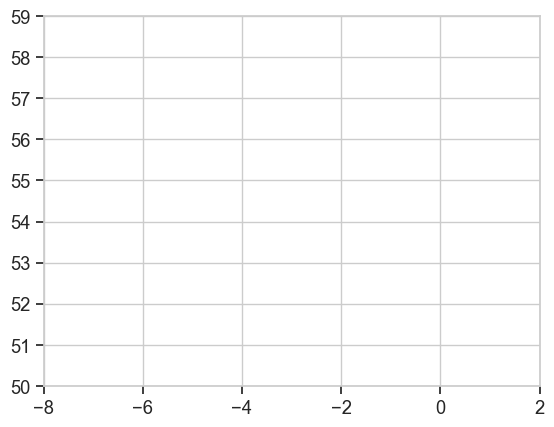

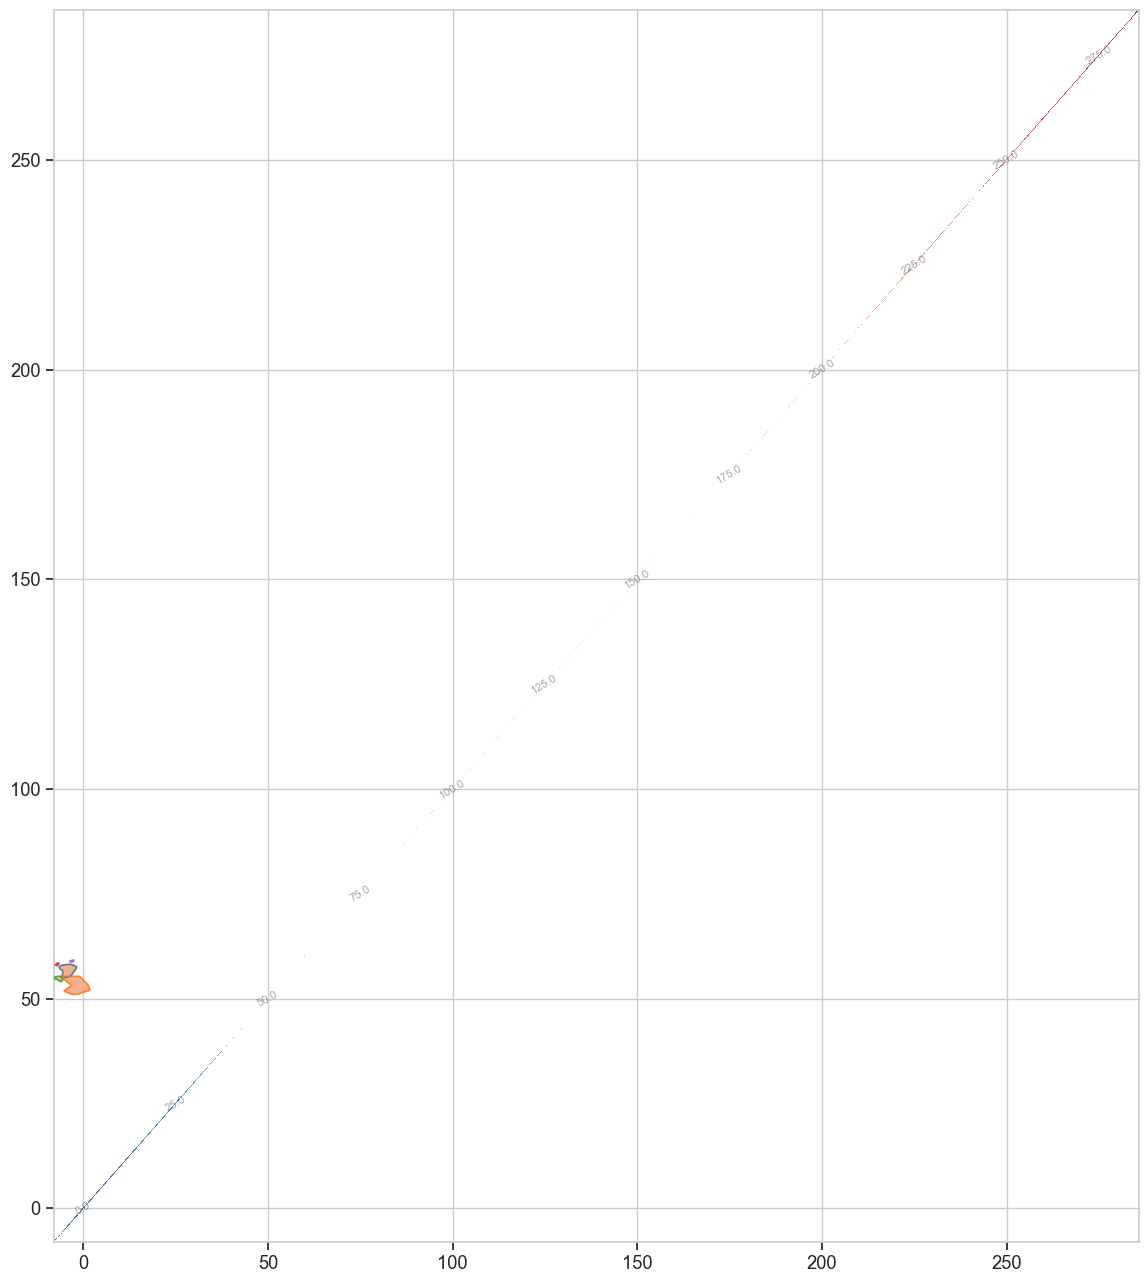

In [58]:
plt.axis([gridLongitude.min(), gridLongitude.max(), gridLatitude.min(), gridLatitude.max()])
makeGeographicPlot(list(zip(gridLongitude, gridLatitude, gridTemperature)), cmap, uk_outline)

C:\Users\John\AppData\Local\Temp\ipykernel_23888\1724042549.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


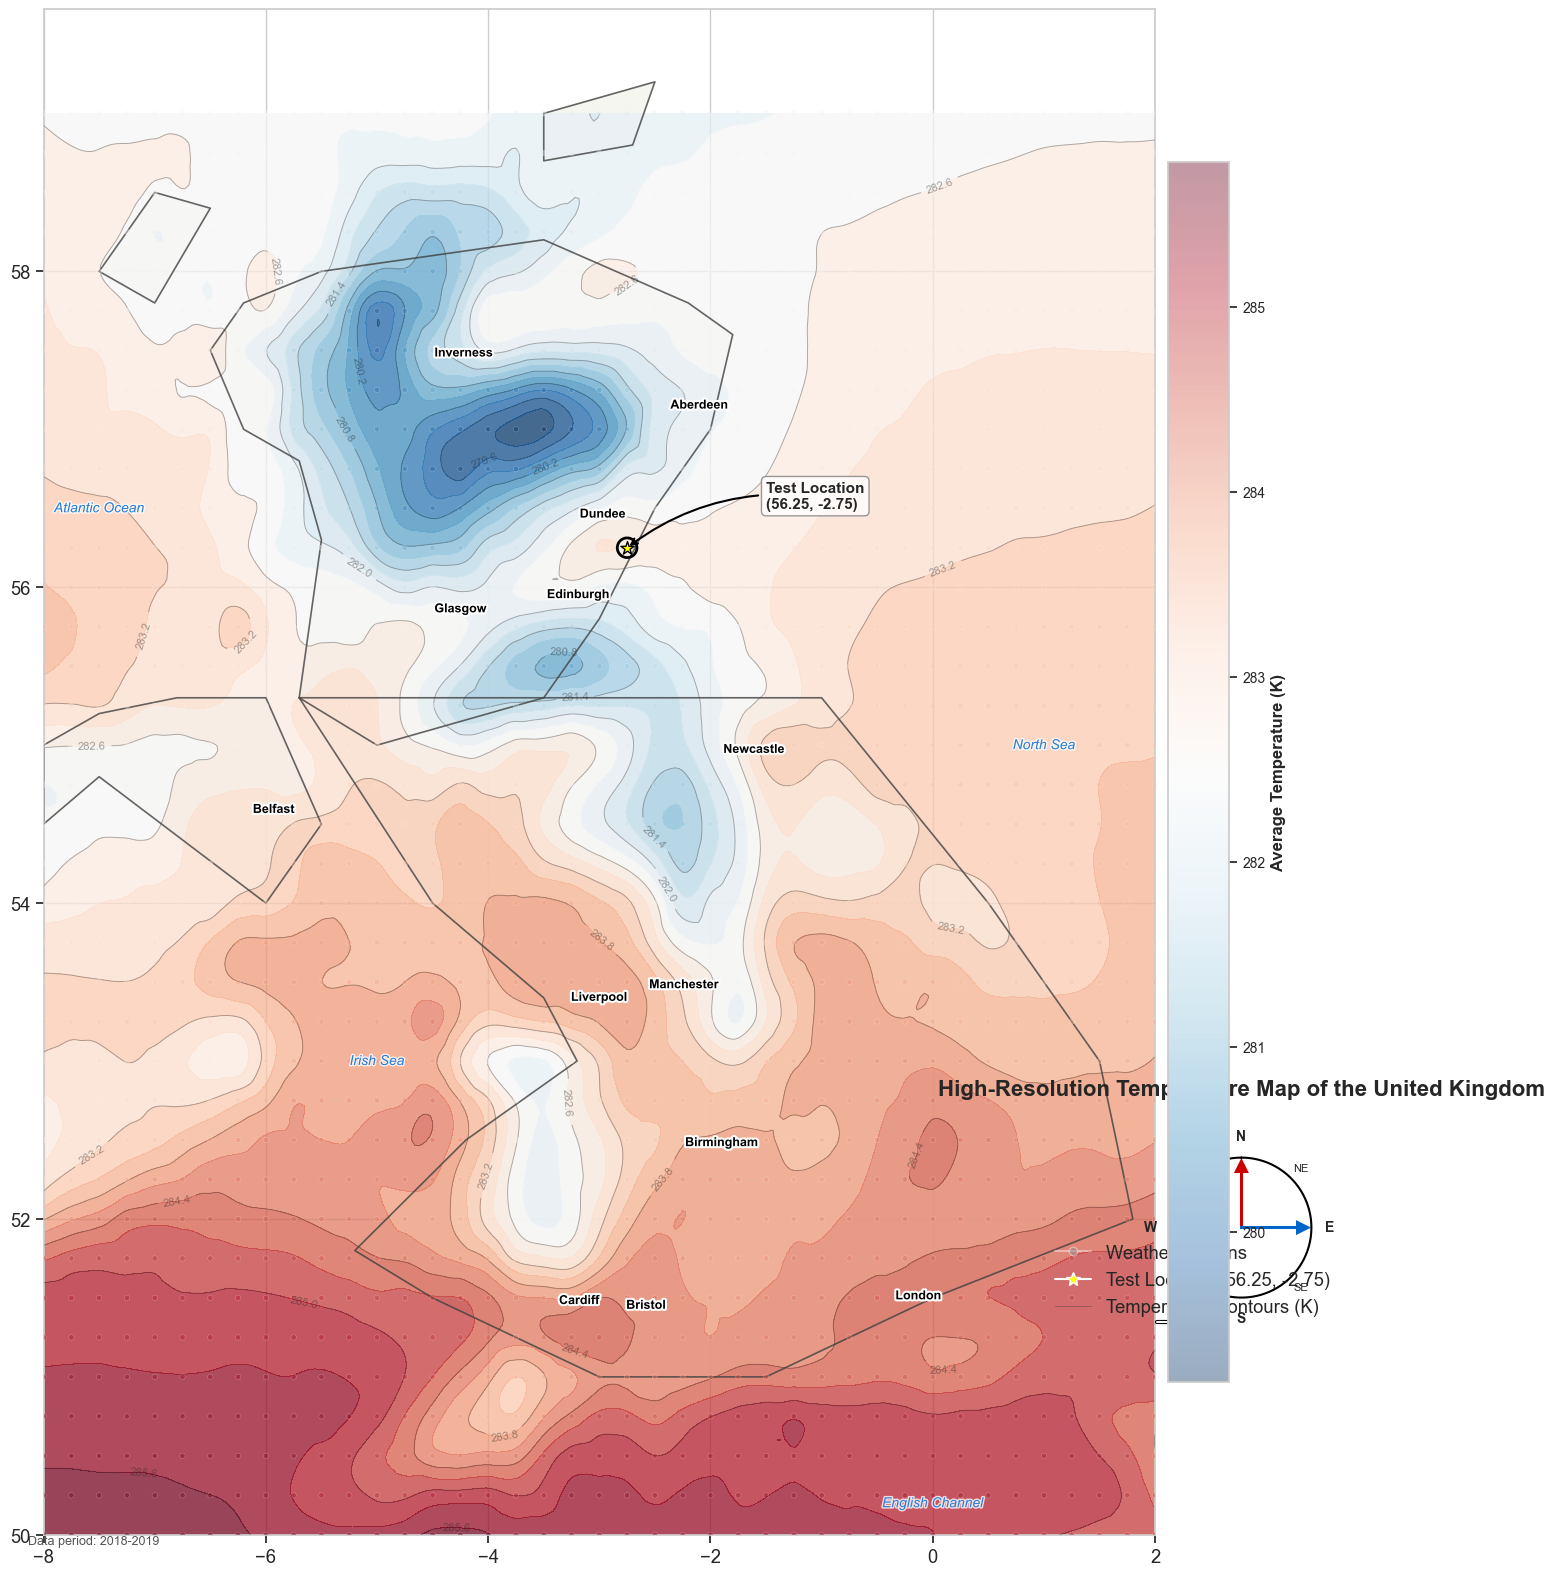

C:\Users\John\AppData\Local\Temp\ipykernel_23888\1724042549.py:284: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


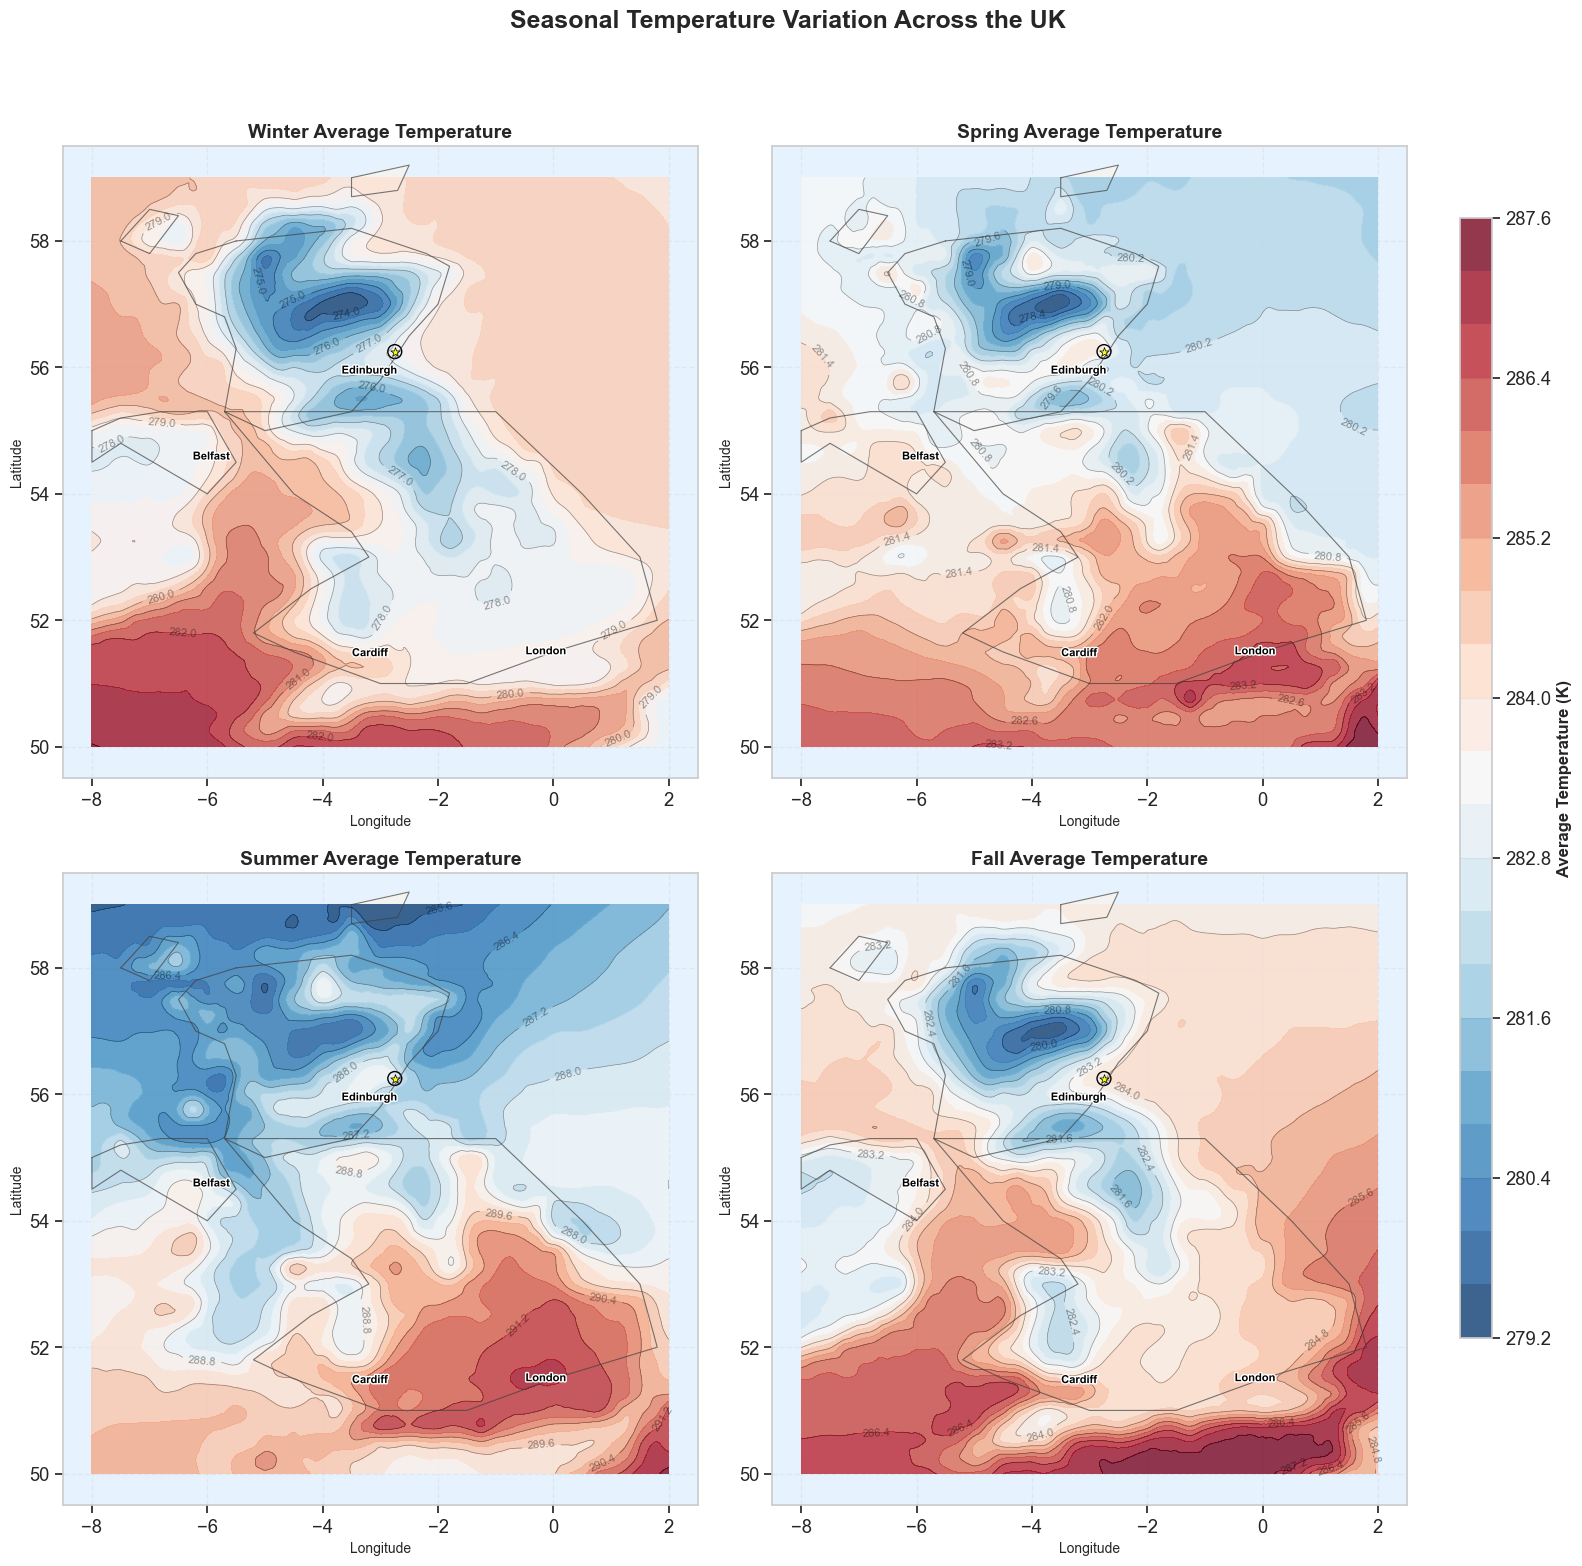

In [32]:
# Set figure aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale = 1.2)

# Prepare the data
temperatureByLocation = dataTrain.groupby(['latitude', 'longitude'])['t2m'].mean().reset_index()

# Create a custom colormap for temperature

colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', 
          '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
cmap = LinearSegmentedColormap.from_list('temp_cmap', colors, N=256)

# Create a higher resolution grid for smoother interpolation
gridLongitude, gridLatitude = np.meshgrid(
    np.linspace(temperatureByLocation.longitude.min(), temperatureByLocation.longitude.max(), 300),
    np.linspace(temperatureByLocation.latitude.min(), temperatureByLocation.latitude.max(), 300)
)

# Interpolate temperature values to the grid using cubic interpolation
gridTemperature = griddata(
    (temperatureByLocation.longitude, temperatureByLocation.latitude), 
    temperatureByLocation.t2m, 
    (gridLongitude, gridLatitude), 
    method = "cubic"
)


# Create figure with larger size and custom background
plt.figure(figsize=(14, 16))
ax = plt.axes()

# Set ocean background color
ax.set_facecolor('#FFFFFF')  # Light blue for ocean

# Create a more sophisticated land effect before plotting data
for region in ['england_wales', 'scotland', 'northern_ireland', 'outer_hebrides', 'orkney']:
    coords = uk_outline[region]
    xs, ys = zip(*coords)
    # Land fill with subtle terrain effect
    plt.fill(xs, ys, color='#f5f5f0', alpha=0.9, zorder=1)  # Light beige/gray for land
    # Coastal highlight
    plt.plot(xs, ys, color='#404040', linewidth=1.2, alpha=0.8, zorder=3)

# Plot the interpolated temperature surface with improved aesthetics
contour = plt.contourf(grid_lon, grid_lat, grid_temp, levels=25, cmap=cmap, alpha=0.75, zorder=2)

# Add contour lines with labels
contour_lines = plt.contour(grid_lon, grid_lat, grid_temp, levels=12, 
                           colors='#404040', alpha=0.4, linewidths=0.7, zorder=4)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f', colors='#202020')

# Add data points (smaller and more subtle)
scatter = plt.scatter(
    temperatureByLocation.longitude, 
    temperatureByLocation.latitude,
    c = temperatureByLocation.t2m, 
    cmap = cmap,
    s = 15,  # Smaller points
    alpha = 0.4,  # More transparent
    edgecolor = 'white',
    linewidth = 0.3,
    zorder = 5
)

# Add major cities and landmarks
cities = {
    'London': (-0.13, 51.51),
    'Edinburgh': (-3.19, 55.95),
    'Cardiff': (-3.18, 51.48),
    'Belfast': (-5.93, 54.59),
    'Manchester': (-2.24, 53.48),
    'Glasgow': (-4.25, 55.86),
    'Liverpool': (-3.0, 53.4),
    'Birmingham': (-1.9, 52.48),
    'Bristol': (-2.58, 51.45),
    'Newcastle': (-1.61, 54.97),
    'Aberdeen': (-2.1, 57.15),
    'Inverness': (-4.22, 57.48),
    'Dundee': (-2.97, 56.46)
}

# Improved city labels with better visibility
for city, (lon, lat) in cities.items():
    # Check if city is within data bounds
    if (temp_by_location.longitude.min() <= lon <= temp_by_location.longitude.max() and
        temp_by_location.latitude.min() <= lat <= temp_by_location.latitude.max()):
        txt = plt.text(lon, lat, city, fontsize=9, ha='center', va='center', 
                      color='black', weight='bold', zorder=10)
        # Add white outline for better visibility
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

# Add main geographical features
geo_features = {
    'North Sea': (1.0, 55.0),
    'Atlantic Ocean': (-7.5, 56.5),
    'Irish Sea': (-5.0, 53.0),
    'English Channel': (0.0, 50.2)
}

for feature, (lon, lat) in geo_features.items():
    # Water features in blue, italic
    txt = plt.text(lon, lat, feature, fontsize=10, ha='center', va='center', 
                  color='#0066cc', style='italic', alpha=0.8, zorder=9)
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

# Highlight test location (56.25, -2.75)
plt.scatter(-2.75, 56.25, s=200, c='none', edgecolor='black', linewidth=2, marker='o', zorder=20)
plt.scatter(-2.75, 56.25, s=100, c='yellow', edgecolor='black', linewidth=1, marker='*', zorder=21)

# Add annotation with better styling
plt.annotate('Test Location\n(56.25, -2.75)', 
             xy=(-2.75, 56.25), 
             xytext=(-1.5, 56.5), 
             fontsize=11, 
             fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', 
                           color='black', lw=1.5),
             zorder=22)

# Add compass rose
compass_size = 0.15
compass_pos = [0.82, 0.15, compass_size, compass_size]
compass_ax = plt.axes(compass_pos)
compass_ax.set_aspect('equal')

# Create detailed compass
theta = np.linspace(0, 2*np.pi, 100)
r = np.ones_like(theta)
compass_ax.plot(r*np.sin(theta), r*np.cos(theta), 'k-', lw=1.5)

# Add directional points
directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
angles = np.arange(0, 2*np.pi, np.pi/4)
for direction, angle in zip(directions, angles):
    x, y = 1.2*np.sin(angle), 1.2*np.cos(angle)
    if direction == 'N':
        compass_ax.text(x, y, direction, ha='center', va='bottom', fontweight='bold', fontsize=10)
    elif direction == 'S':
        compass_ax.text(x, y, direction, ha='center', va='top', fontweight='bold', fontsize=10)
    elif direction == 'E':
        compass_ax.text(x, y, direction, ha='left', va='center', fontweight='bold', fontsize=10)
    elif direction == 'W':
        compass_ax.text(x, y, direction, ha='right', va='center', fontweight='bold', fontsize=10)
    else:
        compass_ax.text(x, y, direction, ha='center', va='center', fontsize=8)

# Main arrows
for angle, color in zip([0, np.pi/2], ['#cc0000', '#0066cc']):
    dx, dy = np.sin(angle), np.cos(angle)
    compass_ax.arrow(0, 0, 0.8*dx, 0.8*dy, head_width=0.15, head_length=0.15, 
                    fc=color, ec=color, lw=2)

compass_ax.set_xlim(-1.5, 1.5)
compass_ax.set_ylim(-1.5, 1.5)
compass_ax.set_axis_off()

# Add scale bar
scale_length_deg = 1.0  # Length in degrees longitude
lon_scale = np.cos(np.radians(56)) * 111  # km per degree longitude at this latitude
scale_length_km = lon_scale * scale_length_deg

# Position scale bar
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
scale_x_start = x_min + 0.1 * (x_max - x_min)
scale_y = y_min + 0.05 * (y_max - y_min)

# Draw scale bar with improved styling
plt.plot([scale_x_start, scale_x_start + scale_length_deg], 
         [scale_y, scale_y], 'k-', linewidth=3)
plt.plot([scale_x_start, scale_x_start + scale_length_deg], 
         [scale_y, scale_y], 'w-', linewidth=1.5)

# Add km label with shadow
scale_txt = plt.text(scale_x_start + scale_length_deg/2, scale_y - 0.2, 
                    f'~{scale_length_km:.0f} km', 
                    ha='center', fontsize=9, fontweight='bold')
scale_txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

# Add better gridlines
plt.grid(True, alpha=0.3, linestyle='--', color='gray')

# Add colorbar with better styling
cbar = plt.colorbar(scatter, pad=0.01, shrink=0.8, aspect=20)
cbar.set_label('Average Temperature (K)', fontsize=12, weight='bold')
cbar.ax.tick_params(labelsize=10)

# Add title and labels
plt.title('High-Resolution Temperature Map of the United Kingdom', 
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Longitude', fontsize=12, weight='bold')
plt.ylabel('Latitude', fontsize=12, weight='bold')

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6, alpha=0.4,
              label='Weather Stations'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='yellow', markersize=10,
              label='Test Location (56.25, -2.75)'),
    plt.Line2D([0], [0], color='#404040', lw=0.7, alpha=0.4,
              label='Temperature Contours (K)')
]
plt.legend(handles=legend_elements, loc='lower right', framealpha=0.7)

# Add date info
plt.annotate('Data period: 2018-2019', xy=(0.02, 0.02), xycoords='figure fraction', 
            fontsize=9, color='#555555')

plt.tight_layout()
plt.show()

# Create a second visualization showing seasonal temperature variation
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

# Create a figure for seasonal comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for i, (season_name, months) in enumerate(seasons.items()):
    # Get data for this season
    season_data = dataTrain[dataTrain['month'].isin(months)]
    season_temp = season_data.groupby(['latitude', 'longitude'])['t2m'].mean().reset_index()
    
    # Interpolate to grid
    season_grid = griddata(
        (season_temp.longitude, season_temp.latitude), 
        season_temp.t2m, 
        (grid_lon, grid_lat), 
        method='cubic'
    )
    
    # Set background color
    axes[i].set_facecolor('#e6f3ff')
    
    # Add UK land
    for region in ['england_wales', 'scotland', 'northern_ireland', 'outer_hebrides', 'orkney']:
        coords = uk_outline[region]
        xs, ys = zip(*coords)
        axes[i].fill(xs, ys, color='#f5f5f0', alpha=0.9, zorder=1)
        axes[i].plot(xs, ys, color='#404040', linewidth=0.8, alpha=0.7, zorder=3)
    
    # Plot contours
    contour = axes[i].contourf(grid_lon, grid_lat, season_grid, levels=20, cmap=cmap, alpha=0.8)
    
    # Add contour lines
    contour_lines = axes[i].contour(grid_lon, grid_lat, season_grid, 
                                   levels=10, colors='black', alpha=0.4, linewidths=0.5)
    axes[i].clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f')
    
    # Add test location highlight
    axes[i].scatter(-2.75, 56.25, s=100, c='none', edgecolor='black', linewidth=1, marker='o')
    axes[i].scatter(-2.75, 56.25, s=50, c='yellow', edgecolor='black', linewidth=0.5, marker='*')
    
    # Add city markers - just a few key cities for each subplot
    major_cities = {k: cities[k] for k in ['London', 'Edinburgh', 'Cardiff', 'Belfast']}
    for city, (lon, lat) in major_cities.items():
        if (season_temp.longitude.min() <= lon <= season_temp.longitude.max() and
            season_temp.latitude.min() <= lat <= season_temp.latitude.max()):
            txt = axes[i].text(lon, lat, city, fontsize=8, ha='center', va='center', 
                         color='black', weight='bold', zorder=7)
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])
    
    # Set limits and labels
    axes[i].set_xlim(temp_by_location.longitude.min() - 0.5, temp_by_location.longitude.max() + 0.5)
    axes[i].set_ylim(temp_by_location.latitude.min() - 0.5, temp_by_location.latitude.max() + 0.5)
    axes[i].set_xlabel('Longitude', fontsize=10)
    axes[i].set_ylabel('Latitude', fontsize=10)
    axes[i].set_title(f'{season_name} Average Temperature', fontsize=14, weight='bold')
    axes[i].grid(True, alpha=0.3, linestyle='--')

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Average Temperature (K)', fontsize=12, weight='bold')

plt.suptitle('Seasonal Temperature Variation Across the UK', fontsize=18, weight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

In [29]:
type(uk_outline)

dict